In [60]:
# inputs

#path to the .csv file created from the VeTrans output
haps_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/F_prev_in/Inference_19_2345.csv"

#path to the Times.in file
times = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

#name of the protein used for plotting
protein_name = "F Protein"


"F Protein"

In [61]:
import Pkg
using Pkg

# Set the Julia environment path
julia_env_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/env"

# Create the folder if it doesn't exist using built-in Julia functions
if !isdir(julia_env_path)
    mkpath(julia_env_path)
end

# Activate the Julia environment
Pkg.activate(julia_env_path)
Pkg.instantiate()


using CSV
using DataFrames
using RCall
using Images
using FileIO
using FilePathsBase
using WebIO

# load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Install the devtools package if not already installed
if (!requireNamespace("devtools", quietly = TRUE))
  install.packages("devtools")

# Load the devtools package
library(devtools)

# Install ggplot2 and viridis with dependencies
install.packages(c("ggplot2", "viridis", "tidyverse", "hrbrthemes", "plotly", "htmlwidgets", "ggridges", "aplot"), dependencies = TRUE)

# Function to check and install missing packages
install_if_missing <- function(package) {
    if (!requireNamespace(package, quietly = TRUE)) {
        BiocManager::install(package)
    } else {
        message(paste(package, "is already installed."))
    }
}

# Ensure BiocManager is installed
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

# Install ggtree and treeio if not already installed
install_if_missing("ggtree")
install_if_missing("treeio")
install_if_missing("ggtreeExtra")
# Load the packages quietly
suppressPackageStartupMessages({
  library("ggplot2")
  library("viridis")
  library("tidyverse")
  library("hrbrthemes")
  library("plotly")
  library("htmlwidgets")
  library("ggridges")
  library("ggtree")
  library("treeio")
  library("ggtreeExtra")
  library("aplot")
})


"""

  Activating project at `~/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/env`



The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//RtmpqROaJm/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/hrbrthemes_0.8.7.tgz'
│ Content type 'application/x-gzip' length 862799 bytes (

RObject{StrSxp}
 [1] "aplot"       "ggtreeExtra" "treeio"      "ggtree"      "ggridges"   
 [6] "htmlwidgets" "plotly"      "hrbrthemes"  "lubridate"   "forcats"    
[11] "stringr"     "dplyr"       "purrr"       "readr"       "tidyr"      
[16] "tibble"      "tidyverse"   "viridis"     "viridisLite" "ggplot2"    
[21] "devtools"    "usethis"     "stats"       "graphics"    "grDevices"  
[26] "utils"       "datasets"    "methods"     "base"       


In [62]:
# load data

haps_wide = CSV.read(haps_path, DataFrame)

# pass into R
@rput haps_wide 

R"""
library(tidyverse)

times <- colnames(haps_wide)[-1]

haps <- haps_wide %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCGGGAAACTACAACAAAGA,1,1.0e-10
2,GGGCCCCCGGGAAACTACAACAAAGA,29,1.00144e-10
3,GGGCCCCCGGGAAACTACAACAAAGA,50,0.0205902
4,GGGCCCCCGGGAAACTACAACAAAGA,74,0.123434
5,GGGCCCCCGGGAAACTACAACAAAGA,83,0.13955
6,GGGCCCCCGGGAAACTACAACAAAGA,99,1.00015e-10
7,GGGCCCCCGGGAAACTACAACAAAGA,111,0.00738175
8,GGGCCCCCGGGAAACTACAACAAAGA,119,0.00861812
9,GGGCCCCCGGGAAACTACAACAAAGA,125,1.0e-10


In [63]:
# zero out smallest frequencies

@rput haps 

# R code to transform the Frequency column
R"""
library(tidyverse)

haps <- haps %>%
  mutate(Frequency = ifelse(Frequency <= 10e-10, 0, Frequency))
"""

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCGGGAAACTACAACAAAGA,1,0.0
2,GGGCCCCCGGGAAACTACAACAAAGA,29,0.0
3,GGGCCCCCGGGAAACTACAACAAAGA,50,0.0205902
4,GGGCCCCCGGGAAACTACAACAAAGA,74,0.123434
5,GGGCCCCCGGGAAACTACAACAAAGA,83,0.13955
6,GGGCCCCCGGGAAACTACAACAAAGA,99,0.0
7,GGGCCCCCGGGAAACTACAACAAAGA,111,0.00738175
8,GGGCCCCCGGGAAACTACAACAAAGA,119,0.00861812
9,GGGCCCCCGGGAAACTACAACAAAGA,125,0.0


In [64]:
# establish the consensus haplotype at time 0

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

The consensus haplotype at the first time point is: GGGCCCCCGAGAAACAACAACAAAGA


In [65]:
# create mutation annotations for each haplotype

# path to single_locus_trajectories file
sl_traj_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/single_locus_trajectories/by_protein/single_locus_trajectories10_F_Fusion_protein.out"
names_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.txt"

# Read the .txt file containing the haplotype names
names = DataFrame(Haplotype=readlines(names_path))

# Function to load the first column from the .out file into a DataFrame
# Function to create the loci DataFrame and add haplotype columns based on the `names` DataFrame
function create_base_loci(filepath::String, consensus::String, names::DataFrame)
    # Initialize an empty Set to store unique first column integers
    first_column_set = Set{Int}()

    # Open the file and read each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Split the line by spaces and convert the first element to an integer
            push!(first_column_set, parse(Int, split(line)[1]))
        end
    end

    # Convert the Set to a sorted vector to create a DataFrame
    first_column_vector = sort(collect(first_column_set))
    
    # Check that the length of the consensus string matches the number of unique loci
    if length(first_column_vector) != length(consensus)
        error("The length of the consensus string must match the number of unique loci.")
    end

    # Create a DataFrame with the extracted unique integers and the consensus_base
    loci = DataFrame(locus = first_column_vector, consensus_base = collect(consensus))
    
    # Iterate over each row in the names DataFrame
    for row in eachrow(names)
        haplotype_string = row[:Haplotype]  # Get the sequence string from the Haplotype column
        column_name = haplotype_string  # Use the haplotype string as the column name

        # Initialize the new column with empty strings
        new_column = Vector{Union{Char, Nothing}}(nothing, length(loci.consensus_base))

        # Fill the new column, skipping matches with the consensus
        for j in 1:length(haplotype_string)
            if haplotype_string[j] != loci.consensus_base[j]
                new_column[j] = haplotype_string[j]
            end
        end

        # Add the new column to the loci DataFrame
        loci[!, Symbol(column_name)] = new_column
    end
    
    return loci
end

# Load the first row of the single_locus_trajectories file
loci = create_base_loci(sl_traj_path, consensus, names)

loci


Row,locus,consensus_base,GGGCCCCCAATAAGCAATAACAAAGG,GGGTCCCCGAGAAACAACAACAAAGA,GGGCCCCCGAGAGACAACAACAAAGA,GGGCCCCCGAGAAACAATAACAAAGA,GGGCCCCCGAGAAACAGCAACAAAGA,GGGCCCCCGAGAAACTACAACAAAGA,GGTCCCCCGAGCAACAGCAACAAAGA,GAGCCTCCGAGAAAATGCACCAAGGG,GGTCCCTCGAGCAACAACAACAAAAA,GGGCCCCCGGGAAACAACAACAAAGA,GGGCCCCTGAGGAACAACAATAGAGG,GGGCCCCCGAGAAACAACAACAAAGA,GAGCCCCCGAGCAACTACAACAAAGA,GGGCTCCCGAGAAAAAACATCGAAGA
,Int64,Char,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…
1,5778,G,,,,,,,,,,,,,,
2,5882,G,,,,,,,,A,,,,,A,
3,5899,G,,,,,,,T,,T,,,,,
4,5925,C,,T,,,,,,,,,,,,
5,6005,C,,,,,,,,,,,,,,T
6,6148,C,,,,,,,,T,,,,,,
7,6169,C,,,,,,,,,T,,,,,
8,6223,C,,,,,,,,,,,T,,,
9,6280,G,A,,,,,,,,,,,,,


In [66]:
# create dataframe of variant positions per haplotype

# Melt the DataFrame to long format, excluding `locus` and `consensus_base`
melted = stack(loci, Not([:locus, :consensus_base]), variable_name=:haplotype, value_name=:variant_base)

# Define a function to check for undesired values
is_valid_variant(value) = !ismissing(value) && value ≠ "N/A" && value ≠ nothing

# Filter out rows where `variant_base` is missing, "N/A", or nothing
filtered = filter(row -> is_valid_variant(row.variant_base), melted)

# Select only relevant columns
variant_loci = filtered[:, [:locus, :consensus_base, :haplotype, :variant_base]]

# Create the 'variant' column by concatenating values
variant_loci.variant = string.(variant_loci.consensus_base) .* string.(variant_loci.locus) .* string.(variant_loci.variant_base)

# Filter for only helpful columns
variant_loci = variant_loci[:, [:haplotype, :variant]]

# Group by "haplotype" and concatenate "variant" values with newline separator
grouped = groupby(variant_loci, :haplotype)
variant_loci_merged = combine(grouped, :variant => (v -> join(v, "\n")))

# Rename the merged column
rename!(variant_loci_merged, :variant_function => :variant)

# Rename haplotype column for joining
rename!(variant_loci_merged, :haplotype => :Haplotype)

# join variant_loci to grouped_haps for annotation

haps = leftjoin(haps, variant_loci_merged, on=:Haplotype)

# Replace missing values in the 'variant' column with "Consensus"
haps.variant = coalesce.(haps.variant, "Consensus")

# print
println(haps)

200×4 DataFrame
 Row │ Haplotype                   Time    Frequency    variant   
     │ String                      String  Float64      String    
─────┼────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACTACAACAAAGA  1       0.0          A6507T
   2 │ GGGCCCCCGAGAAACTACAACAAAGA  29      0.0          A6507T
   3 │ GGGCCCCCGAGAAACTACAACAAAGA  50      0.0          A6507T
   4 │ GGGCCCCCGAGAAACTACAACAAAGA  74      0.0          A6507T
   5 │ GGGCCCCCGAGAAACTACAACAAAGA  83      0.139287     A6507T
   6 │ GGGCCCCCGAGAAACTACAACAAAGA  99      0.522748     A6507T
   7 │ GGGCCCCCGAGAAACTACAACAAAGA  111     0.351208     A6507T
   8 │ GGGCCCCCGAGAAACTACAACAAAGA  119     0.337169     A6507T
   9 │ GGGCCCCCGAGAAACTACAACAAAGA  125     0.0          A6507T
  10 │ GGGCCCCCGAGAAACTACAACAAAGA  140     0.00192042   A6507T
  11 │ GGGCCCCCGAGAAACAGCAACAAAGA  1       0.326455     A6518G
  12 │ GGGCCCCCGAGAAACAGCAACAAAGA  29      0.731709     A6518G
  13 │ GGGCCCCCGAGAAACAGCAA

In [67]:
# generate variant_label column in Julia

# Function to format the variant column
function format_variant(variant::String)
    words = split(variant, r"\n")
    formatted_words = []
    
    for (i, word) in enumerate(words)
        push!(formatted_words, word)
        if i % 4 == 0 && i < length(words)
            push!(formatted_words, "\n")
        else
            push!(formatted_words, " ")
        end
    end
    
    return join(formatted_words, "")
end

# Apply the function to create the variant_label column
haps[:, "variant_label"] = format_variant.(haps.variant)

# Display the updated DataFrame
println(haps)

200×5 DataFrame
 Row │ Haplotype                   Time    Frequency    variant    variant_label 
     │ String                      String  Float64      String     String        
─────┼───────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACTACAACAAAGA  1       0.0          A6507T     A6507T
   2 │ GGGCCCCCGAGAAACTACAACAAAGA  29      0.0          A6507T     A6507T
   3 │ GGGCCCCCGAGAAACTACAACAAAGA  50      0.0          A6507T     A6507T
   4 │ GGGCCCCCGAGAAACTACAACAAAGA  74      0.0          A6507T     A6507T
   5 │ GGGCCCCCGAGAAACTACAACAAAGA  83      0.139287     A6507T     A6507T
   6 │ GGGCCCCCGAGAAACTACAACAAAGA  99      0.522748     A6507T     A6507T
   7 │ GGGCCCCCGAGAAACTACAACAAAGA  111     0.351208     A6507T     A6507T
   8 │ GGGCCCCCGAGAAACTACAACAAAGA  119     0.337169     A6507T     A6507T
   9 │ GGGCCCCCGAGAAACTACAACAAAGA  125     0.0          A6507T     A6507T
  10 │ GGGCCCCCGAGAAACTACAACAAAGA  140     0.00192042   A6507T     A6507

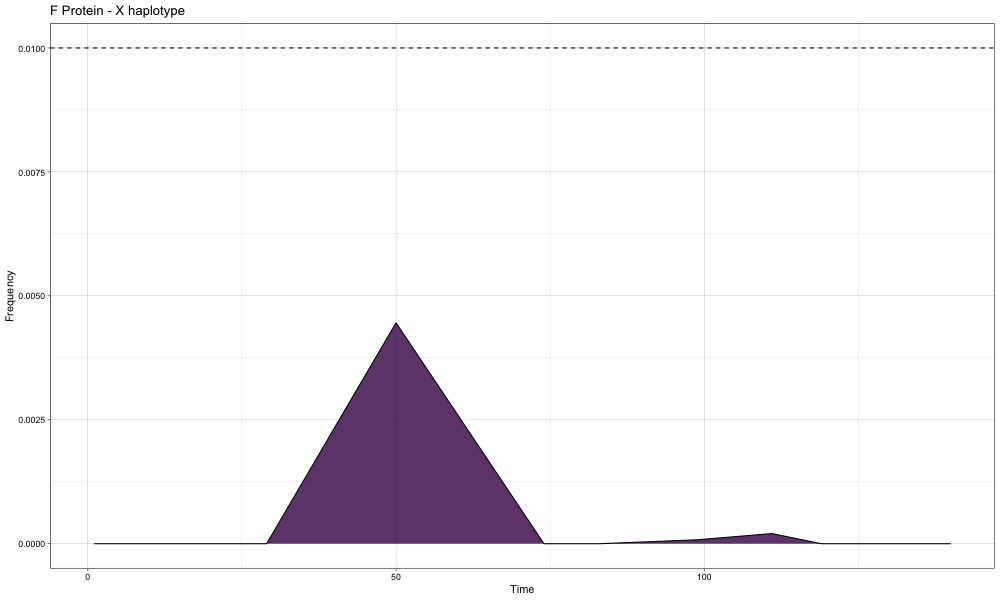

Temporary file deleted successfully.


In [68]:
# plot to check X haplotype frequencies

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""

p <- haps %>% filter(str_detect(Haplotype, "^X+$")) %>% 
    ggplot(aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    geom_hline(yintercept = 0.01, linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = paste(protein_name, "- X haplotype"), x = "Time", y = "Frequency") +
    theme(legend.position = "none") +
    scale_fill_viridis(discrete = TRUE, direction = 1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

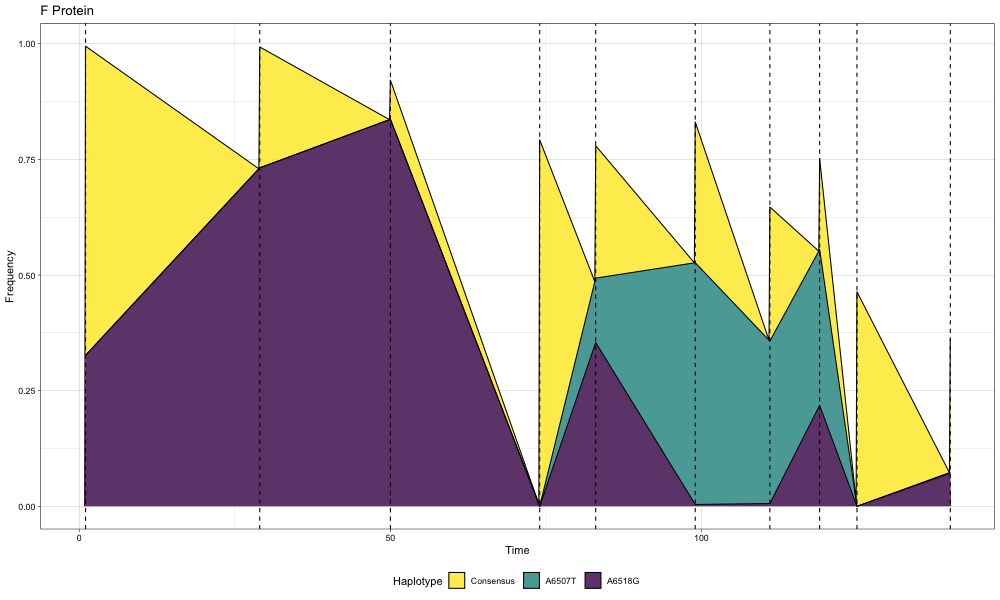

Temporary file deleted successfully.


In [69]:
# plot

@rput haps # pass back to R
@rput protein_name
@rput haps_path

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Identify the variant label with the highest frequency at the minimum time point
highest_freq_label <- haps %>%
  filter(Time == min(Time)) %>%
  arrange(desc(Frequency)) %>%
  slice(1) %>%
  pull(variant_label)

# Reorder variant_label: first the highest frequency, then by length
haps <- haps %>%
  mutate(variant_label = factor(variant_label,
                                levels = c(highest_freq_label, 
                                           unique(variant_label) %>% 
                                             setdiff(highest_freq_label) %>% 
                                             .[order(nchar(.))])
                                )
         )

# Sort haplotypes by their initial frequency
first_time_point <- haps %>% 
  filter(Time == min(Time)) %>% 
  arrange(desc(Frequency)) %>% 
  select(variant_label, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset, with many-to-many relationship allowed
haps <- haps %>%
  left_join(first_time_point, by = "variant_label", relationship = "many-to-many") %>%
  arrange(desc(InitialFrequency), Time, Frequency)

# Create a color palette with the same number of colors as unique haplotypes
num_haplotypes <- length(unique(haps$variant_label))
haplotype_colors <- viridis::viridis(num_haplotypes, direction = -1)

# Create the plot
p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = variant_label)) + 
  geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
  geom_vline(xintercept = unique(as.numeric(haps$Time)), linetype = "dashed", color = "black") +
  theme_linedraw() +
  labs(title = protein_name, x = "Time", y = "Frequency", fill = "Haplotype") +
  theme(legend.position = "bottom", legend.spacing.x = unit(5, "lines")) +
  scale_fill_manual(values = haplotype_colors)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [70]:
# Function to calculate Hamming distance between two strings
function hamming_distance(s1::String, s2::String)::Int
    return sum(c1 != c2 for (c1, c2) in zip(s1, s2))
end

# Add new column with Hamming Distance
haps.ham_dist = [hamming_distance(row.Haplotype, consensus) for row in eachrow(haps)]

# Calculate the length of the consensus string
string_length = length(consensus)

# Filter out rows where ham_dist equals the string length
haps_filtered = haps[haps.ham_dist .!= string_length, :]

println(haps_filtered)

# Group the filtered DataFrame by the 'Mismatches' column
@rput haps_filtered
R"""
# Grouping by Time and ham_dist, then summing Frequency
haps_dist <- haps_filtered %>%
    group_by(Time, ham_dist) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_dist

190×6 DataFrame
 Row │ Haplotype                   Time    Frequency    variant    variant_label  ham_dist 
     │ String                      String  Float64      String     String         Int64    
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCGAGAAACTACAACAAAGA  1       0.0          A6507T     A6507T                1
   2 │ GGGCCCCCGAGAAACTACAACAAAGA  29      0.0          A6507T     A6507T                1
   3 │ GGGCCCCCGAGAAACTACAACAAAGA  50      0.0          A6507T     A6507T                1
   4 │ GGGCCCCCGAGAAACTACAACAAAGA  74      0.0          A6507T     A6507T                1
   5 │ GGGCCCCCGAGAAACTACAACAAAGA  83      0.139287     A6507T     A6507T                1
   6 │ GGGCCCCCGAGAAACTACAACAAAGA  99      0.522748     A6507T     A6507T                1
   7 │ GGGCCCCCGAGAAACTACAACAAAGA  111     0.351208     A6507T     A6507T                1
   8 │ GGGCCCCCGAGAAACTACAACAAAGA  119     0.337169     A6507T     A650

Row,Time,ham_dist,Frequency
,String,Int64,Float64
1,1,0,0.668347
2,1,1,0.326455
3,1,2,0.0
4,1,3,0.000303325
5,1,4,0.0
6,1,5,0.00460924
7,1,6,0.0
8,1,7,0.000285142
9,111,0,0.110323


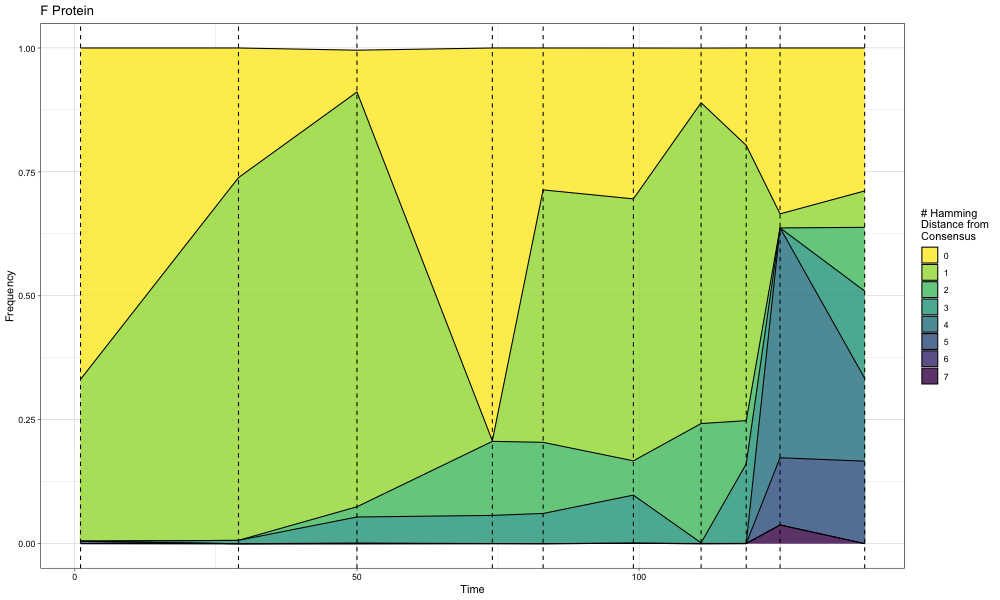

Temporary file deleted successfully.


In [71]:
# area plot for counts of mutations
# plot

@rput haps_dist # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types
haps_dist$Frequency <- as.numeric(unlist(haps_dist$Frequency))
haps_dist$ham_dist <- as.factor(as.character(unlist(haps_dist$ham_dist)))
haps_dist$Time <- as.numeric(unlist(haps_dist$Time))

p <- haps_dist %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = as.factor(ham_dist))) + 
    geom_area(alpha = 0.8 , linewidth = 0.5, colour = "black") +
    geom_vline(xintercept = unique(as.numeric(haps$Time)), linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "# Hamming\nDistance from\nConsensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end

The next plot requires input from Blanche (https://github.com/cjri/Blanche.git). 

In [72]:
using CSV
using DataFrames

# Define the file paths
blanche_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.dat"


# Read the .dat file and select the first two columns
df_coords = CSV.read(blanche_path, DataFrame; header=false, delim=" ", select=[1, 2])



# Combine the two DataFrames
blanche = hcat(df_coords, names)

# Rename the columns to "x", "y", and "Haplotype"
rename!(blanche, [:x, :y, :Haplotype])

# Find the coordinates of the consensus haplotype
consensus_coords = blanche[blanche.Haplotype .== consensus, [:x, :y]]
if nrow(consensus_coords) == 0
    error("Consensus haplotype not found in the dataframe.")
end

consensus_x, consensus_y = consensus_coords[1, :x], consensus_coords[1, :y]

# Compute the adjustment amounts
blanche.x .-= consensus_x
blanche.y .-= consensus_y

# Set the coordinates for the consensus haplotype to (0, 0)
blanche[blanche.Haplotype .== consensus, :x] .= 0.0
blanche[blanche.Haplotype .== consensus, :y] .= 0.0

# Join the updated coordinates with haps
haps = innerjoin(haps, blanche, on=:Haplotype)

# Display the joined dataframe
haps

Row,Haplotype,Time,Frequency,variant,variant_label,ham_dist,x,y
,String,String,Float64,String,String,Int64,Float64,Float64
1,GGGCCCCCGAGAAACTACAACAAAGA,1,0.0,A6507T,A6507T,1,0.821872,-0.150262
2,GGGCCCCCGAGAAACTACAACAAAGA,29,0.0,A6507T,A6507T,1,0.821872,-0.150262
3,GGGCCCCCGAGAAACTACAACAAAGA,50,0.0,A6507T,A6507T,1,0.821872,-0.150262
4,GGGCCCCCGAGAAACTACAACAAAGA,74,0.0,A6507T,A6507T,1,0.821872,-0.150262
5,GGGCCCCCGAGAAACTACAACAAAGA,83,0.139287,A6507T,A6507T,1,0.821872,-0.150262
6,GGGCCCCCGAGAAACTACAACAAAGA,99,0.522748,A6507T,A6507T,1,0.821872,-0.150262
7,GGGCCCCCGAGAAACTACAACAAAGA,111,0.351208,A6507T,A6507T,1,0.821872,-0.150262
8,GGGCCCCCGAGAAACTACAACAAAGA,119,0.337169,A6507T,A6507T,1,0.821872,-0.150262
9,GGGCCCCCGAGAAACTACAACAAAGA,125,0.0,A6507T,A6507T,1,0.821872,-0.150262


In [73]:
# try using plot_ly()

@rput haps
@rput protein_name
@rput haps_path

R"""
# Define html_path by replacing .csv with .html
html_path <- sub("\\.csv$", ".html", haps_path)

# Define folder_path by extracting the directory name from haps_path
folder_path <- dirname(haps_path)

# Get working directory for resetting later
home_wd <- getwd()

# Generate Day column for plotting
haps <- haps %>%
  mutate(
    tooltip_text = ifelse(is.na(variant),
                          "Consensus",  # Show only "Consensus" when variant is NA
                          variant),  # Show only the variant when it's not NA
    Day = as.numeric(Time)  # Ensure Time is numeric and assign it to Day
  )

# Function to interpolate the size (Frequency) between days without moving the points
interpolate_sizes <- function(data, n = 10) {
  full_data <- data.frame()
  
  unique_days <- sort(unique(data$Day))
  
  for (i in seq_along(unique_days)[-length(unique_days)]) {
    start_day <- unique_days[i]
    end_day <- unique_days[i + 1]
    
    day_seq <- seq(start_day, end_day, length.out = n)
    
    start_data <- data %>% filter(Day == start_day)
    end_data <- data %>% filter(Day == end_day)
    
    for (j in seq_along(day_seq)) {
      fraction <- (day_seq[j] - start_day) / (end_day - start_day)
      
      interp_data <- start_data %>%
        mutate(
          Day = day_seq[j],
          Frequency = (1 - fraction) * Frequency + fraction * end_data$Frequency
        )
      
      full_data <- rbind(full_data, interp_data)
    }
  }
  
  return(full_data)
}

# Interpolate between sizes for smooth animation
haps_interpolated <- interpolate_sizes(haps, n = 10)  # n = number of frames to interpolate between each Day

# Define the original time points present in the data
original_times <- sort(unique(haps$Day))

# Generate the smooth animation without slider and without Frequency in hovertext
p_smooth <- plot_ly(haps_interpolated, 
                    x = ~x, 
                    y = ~y, 
                    size = ~ifelse(Frequency > 0, Frequency, NA),
                    color = ~-ham_dist, 
                    frame = ~Day,  # Use interpolated 'Day' as the frame for the animation
                    type = 'scatter',
                    mode = 'markers',
                    text = ~tooltip_text,  # Use updated tooltip_text without Frequency
                    hoverinfo = 'text',
                    marker = list(sizemode = 'diameter'),  # Specify marker settings
                    sizes = c(0, 100)) %>%  # Set the minimum and maximum marker sizes
  hide_colorbar() %>%  # Hide the colorbar
  layout(title = protein_name,
         xaxis = list(title = 'Dimension 1', 
                      range = c(min(haps$x) - 0.5, max(haps$x) + 0.5)),
         yaxis = list(title = 'Dimension 2', 
                      range = c(min(haps$y) - 0.5, max(haps$y) + 0.5)),
         updatemenus = list(
           list(
             type = "buttons",
             direction = "left",
             x = 0.1,
             y = 1.2,
             showactive = TRUE,
             buttons = list(
               list(
                 label = "Play",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0, easing = "linear"), 
                                        frame = list(duration = 30, redraw = FALSE)))
               ),
               list(
                 label = "Pause",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0), 
                                        frame = list(duration = 0, redraw = FALSE)))
               )
             )
           )
         )
  ) %>%
  animation_opts(
    frame = 30,
    transition = 0,
    easing = "linear",
    redraw = FALSE,
    mode = "immediate"
  ) %>%
  animation_slider(hide = TRUE)  # Hide the slider

# Save the smooth animation without slider
smooth_html_path <- sub(".html", "_smooth.html", html_path)
setwd(folder_path)  # Trick to get single file HTML
htmlwidgets::saveWidget(p_smooth, smooth_html_path, selfcontained = TRUE)

# Generate the non-interpolated animation with slider
p_slider <- plot_ly(haps, 
                    x = ~x, 
                    y = ~y, 
                    size = ~ifelse(Frequency > 0, Frequency, NA),
                    color = ~-ham_dist, 
                    frame = ~Day,  # Use original 'Day' as the frame for the animation
                    type = 'scatter',
                    mode = 'markers',
                    text = ~tooltip_text,
                    hoverinfo = 'text',
                    marker = list(sizemode = 'diameter'),  # Specify marker settings
                    sizes = c(0, 100)) %>%  # Set the minimum and maximum marker sizes
  hide_colorbar() %>%  # Hide the colorbar
  layout(title = protein_name,
         xaxis = list(title = 'Dimension 1', 
                      range = c(min(haps$x) - 0.5, max(haps$x) + 0.5)),
         yaxis = list(title = 'Dimension 2', 
                      range = c(min(haps$y) - 0.5, max(haps$y) + 0.5)),
         updatemenus = list(
           list(
             type = "buttons",
             showactive = FALSE,
             buttons = list(
               list(
                 label = "Play",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0, easing = "linear"), 
                                        frame = list(duration = 500, redraw = TRUE)))
               ),
               list(
                 label = "Pause",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0), 
                                        frame = list(duration = 0, redraw = FALSE)))
               )
             )
           )
         ),
         sliders = list(list(
           active = 0,
           steps = lapply(original_times, function(time) {
             list(
               label = paste("Day", time),
               method = "animate",
               args = list(list(frame = list(duration = 0, redraw = TRUE), mode = "immediate"),
                           list(frame = as.character(time)))
             )
           }),
           currentvalue = list(prefix = "Day: ", font = list(size = 20, color = "black")),
           pad = list(t = 50),
           x = 0.1,
           len = 0.9
         )))

# Save the non-interpolated animation with slider
slider_html_path <- sub(".html", "_slider.html", html_path)
setwd(folder_path)  # Trick to get single file HTML
htmlwidgets::saveWidget(p_slider, slider_html_path, selfcontained = TRUE)

# Construct and return the output messages
output_messages <- paste(
  "Smooth file saved at", smooth_html_path, ". This can be opened in your browser.",
  "Slider file saved at", slider_html_path, ". This can be opened in your browser."
)

# Reset the working directory
setwd(home_wd)

# Return the messages as output
output_messages
"""

┌ Warning: RCall.jl: Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does 

RObject{StrSxp}
[1] "Smooth file saved at /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/F_prev_in/Inference_19_2345_smooth.html . This can be opened in your browser. Slider file saved at /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/F_prev_in/Inference_19_2345_slider.html . This can be opened in your browser."


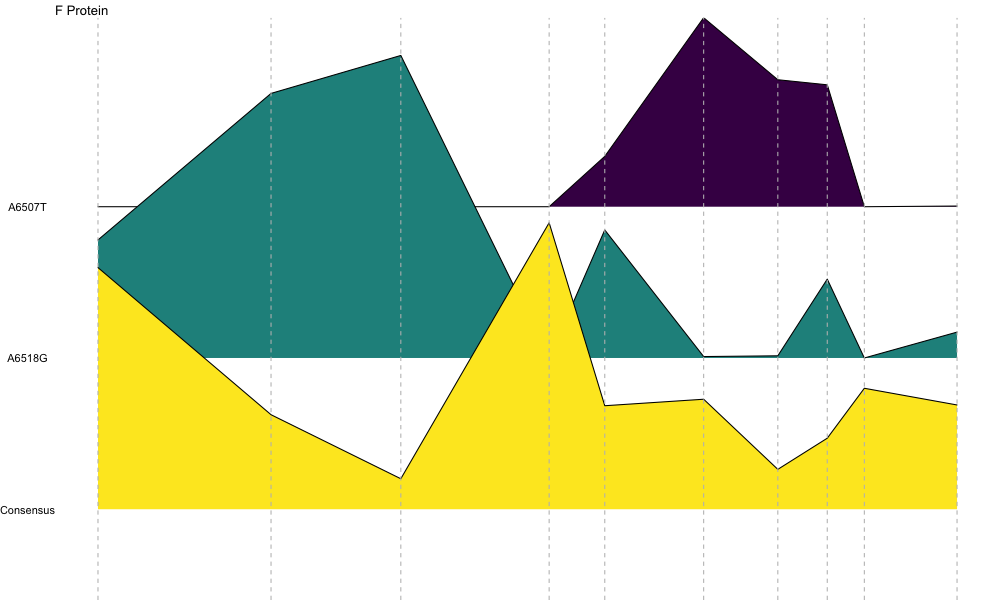

Temporary file deleted successfully.


In [74]:
@rput haps
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

R"""
# Function to add \n after every fourth word
add_newlines <- function(text) {
  words <- str_split(text, " ")[[1]]
  newline_text <- paste0(sapply(seq_along(words), function(i) {
    if (i %% 4 == 0) {
      paste0(words[i], "\n")
    } else {
      words[i]
    }
  }), collapse = " ")
  str_replace_all(newline_text, " \n", "\n")
}

# Create the variant_label column and modify it with newlines
haps <- haps %>%
  mutate(variant_label = ifelse(is.na(variant), "Consensus", gsub("\n", " ", variant))) %>%
  mutate(variant_label = sapply(variant_label, add_newlines))

# Find the frequency at the lowest time point and the timepoint of the highest Frequency
haps_freq_and_max_time <- haps %>%
  group_by(ham_dist, variant_label) %>%
  summarise(
    freq_at_min_time = Frequency[which.min(Time)], 
    max_time = min(Time[which.max(Frequency)]), 
    .groups = 'drop'
  )

# Sort by ham_dist, then by freq_at_min_time, and finally by max_time within each ham_dist group
haps_sorted <- haps %>%
  left_join(haps_freq_and_max_time, by = c("ham_dist", "variant_label")) %>%
  arrange(ham_dist, desc(freq_at_min_time), max_time)

# Ensure unique levels by removing duplicates
haps_sorted <- haps_sorted %>% distinct(variant_label, .keep_all = TRUE)

# Merge the sorted Haplotype order back into the main dataset
haps_arranged <- haps %>%
  mutate(variant_label = factor(variant_label, levels = haps_sorted$variant_label))

p <- ggplot(haps_arranged, aes(x = as.numeric(Time), y = variant_label, fill = variant_label)) +
  geom_density_ridges(aes(height = as.numeric(Frequency)), stat = "identity", scale = 2) +  # Adjust scale for closer ridges
  geom_vline(xintercept = unique(as.numeric(haps$Time)), linetype = "dashed", color = "grey") +
  theme_void() + 
  labs(title = protein_name, x = "Time", y = "Haplotype") +
  scale_fill_viridis(discrete = TRUE, direction = -1) +
  theme(legend.position = "none", 
        axis.text.y = element_text(hjust = 0.5))  # Center the y-axis text

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)
  
    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

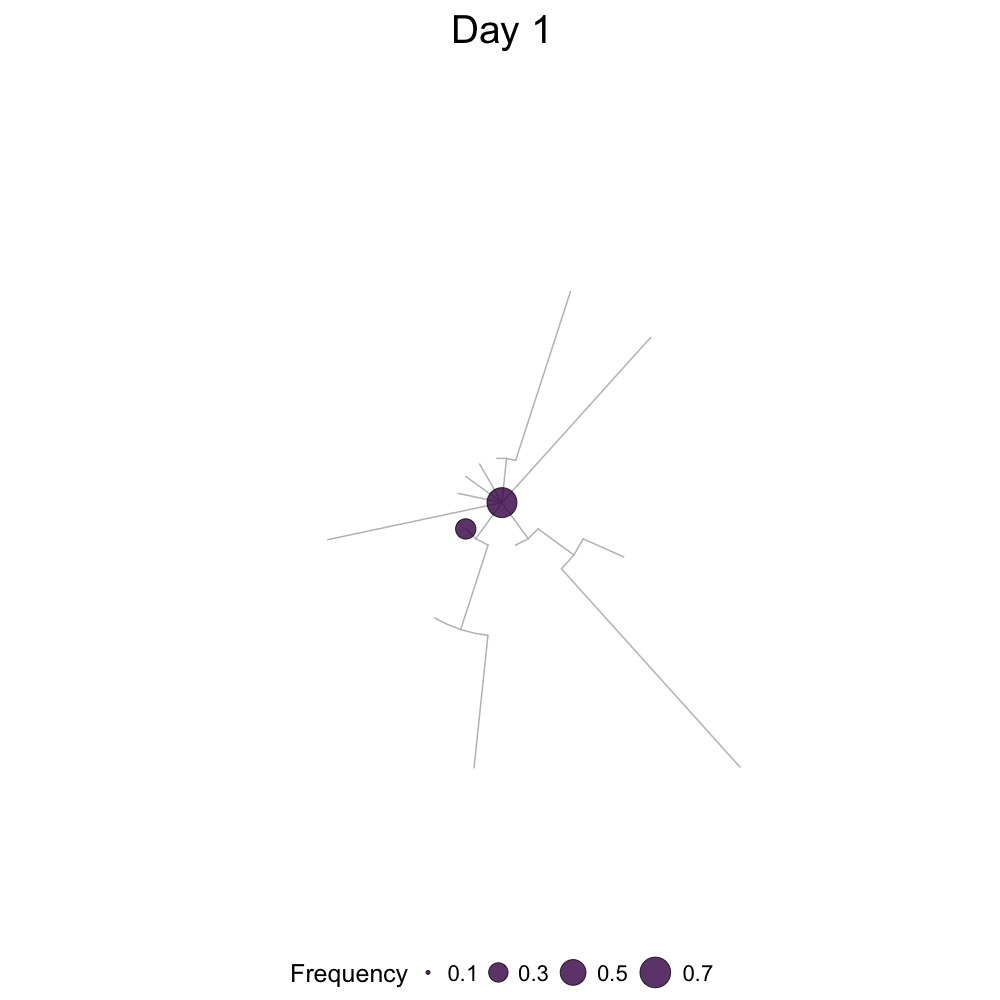

Temporary file deleted successfully.


┌ Warning: RCall.jl: Scale for y is already present.
│ Adding another scale for y, which will replace the existing scale.
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/FEbLj/src/io.jl:172
┌ Warning: RCall.jl: Warning: Removed 24 rows containing missing values or values outside the scale range
│ (`geom_point()`).
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/FEbLj/src/io.jl:172


In [75]:
# Pass metadata to R
@rput haps
@rput times

# Set the directory path for the output images
output_directory = joinpath(pwd(), "ggplot_output")
@rput output_directory

# Create the output directory if it doesn't exist
isdir(output_directory) || mkpath(output_directory)

# R code to generate plots
R"""
# Read the tree file
tree <- read.tree("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/iqtree/F_haplotypes/14/Consensus0_F_14_haplotypes_JC.treefile")

# Merge metadata with tree data, removing any rows with missing values and filtering out frequency = 0
tree_data <- ggtree::fortify(tree) %>% 
  left_join(haps, by = c("label" = "Haplotype")) %>%
  filter(Time == 1, Frequency > 0) %>%  # Filter out frequency = 0
  na.omit()  # Remove rows with missing values

# Define the max size for the points
max_point_size <- 10

# Extract the Time value (assuming it's consistent across all rows in tree_data)
time_value <- unique(tree_data$Time)

# Choose a color from the Viridis palette closer to the yellow end
selected_color <- viridis::viridis(1)  # Choose a color close to the yellow end of the spectrum

# Create the plot with scaled branch lengths and thinner lines
p <- ggtree(tree, layout = "fan", color = "grey") %<+% tree_data +
  geom_point(aes(size = Frequency), 
             fill = selected_color,  # Set all points to the chosen color
             shape = 21, color = "black", alpha = 0.8) +  # Set alpha to 0.8
  ggtitle(paste("Day", time_value)) +  # Add the dynamic title
  scale_size_continuous(name = "Frequency", 
                        range = c(1, max_point_size),  # Control point size
                        breaks = c(0.1, 0.3, 0.5, 0.7),  # Explicit breaks
                        limits = c(0.1, 0.7)) +  # Limit the size range
  theme(legend.position = "bottom",
        plot.title = element_text(size = 28, hjust = 0.5, vjust = 1, margin = margin(t = 5, b = 5)),  # Center title and reduce space
        legend.text = element_text(size = 16),  # Increase legend text size
        legend.title = element_text(size = 18),  # Increase legend title size
        legend.margin = margin(t = -10),  # Move legend closer to the plot
        plot.margin = unit(c(2, 2, 2, 2), "mm"))  # Reduce margins around the plot

# Save the plot with adjusted resolution and dimensions
png(filename = $output_path, width = 1000, height = 1000, res = 100)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
  img = load(output_path)
  display(img)

  # Delete the temporary image file after displaying
  rm(output_path; force = true)
  println("Temporary file deleted successfully.")
else
  println("File does not exist.")
end

In [76]:
# generate tree part of plot and extract variant order

# Pass metadata to R
@rput haps

# R code to generate plots
R"""
# Read the tree file
tree <- read.tree("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/iqtree/F_haplotypes/14/Consensus0_F_14_haplotypes_JC.treefile")

# Merge metadata with tree data, removing any rows with missing values and filtering out frequency = 0
tree_data <- ggtree::fortify(tree) %>% 
  left_join(haps, by = c("label" = "Haplotype")) %>%
  filter(Time == 1, Frequency > 0) %>%  # Filter out frequency = 0
  na.omit()  # Remove rows with missing values

# Define the max size for the points
max_point_size <- 10

# Extract the Time value (assuming it's consistent across all rows in tree_data)
time_value <- unique(tree_data$Time)

# Choose a color from the Viridis palette closer to the yellow end
selected_color <- viridis::viridis(1)  # Choose a color close to the yellow end of the spectrum

# Create the plot with scaled branch lengths and thinner lines
tree_plot <- ggtree(tree) %<+% tree_data +
  geom_tiplab(aes(label = ""), align = TRUE)

tree_order <- get_taxa_name(tree_plot)
"""

RObject{StrSxp}
 [1] "GAGCCCCCGAGCAACTACAACAAAGA" "GAGCCTCCGAGAAAATGCACCAAGGG"
 [3] "GGGCCCCCGAGAAACTACAACAAAGA" "GGTCCCTCGAGCAACAACAACAAAAA"
 [5] "GGTCCCCCGAGCAACAGCAACAAAGA" "GGGCCCCCGAGAAACAGCAACAAAGA"
 [7] "GGGCTCCCGAGAAAAAACATCGAAGA" "GGGCCCCCGGGAAACAACAACAAAGA"
 [9] "GGGCCCCCGAGAGACAACAACAAAGA" "GGGTCCCCGAGAAACAACAACAAAGA"
[11] "GGGCCCCCGAGAAACAATAACAAAGA" "GGGCCCCCAATAAGCAATAACAAAGG"
[13] "GGGCCCCTGAGGAACAACAATAGAGG" "GGGCCCCCGAGAAACAACAACAAAGA"


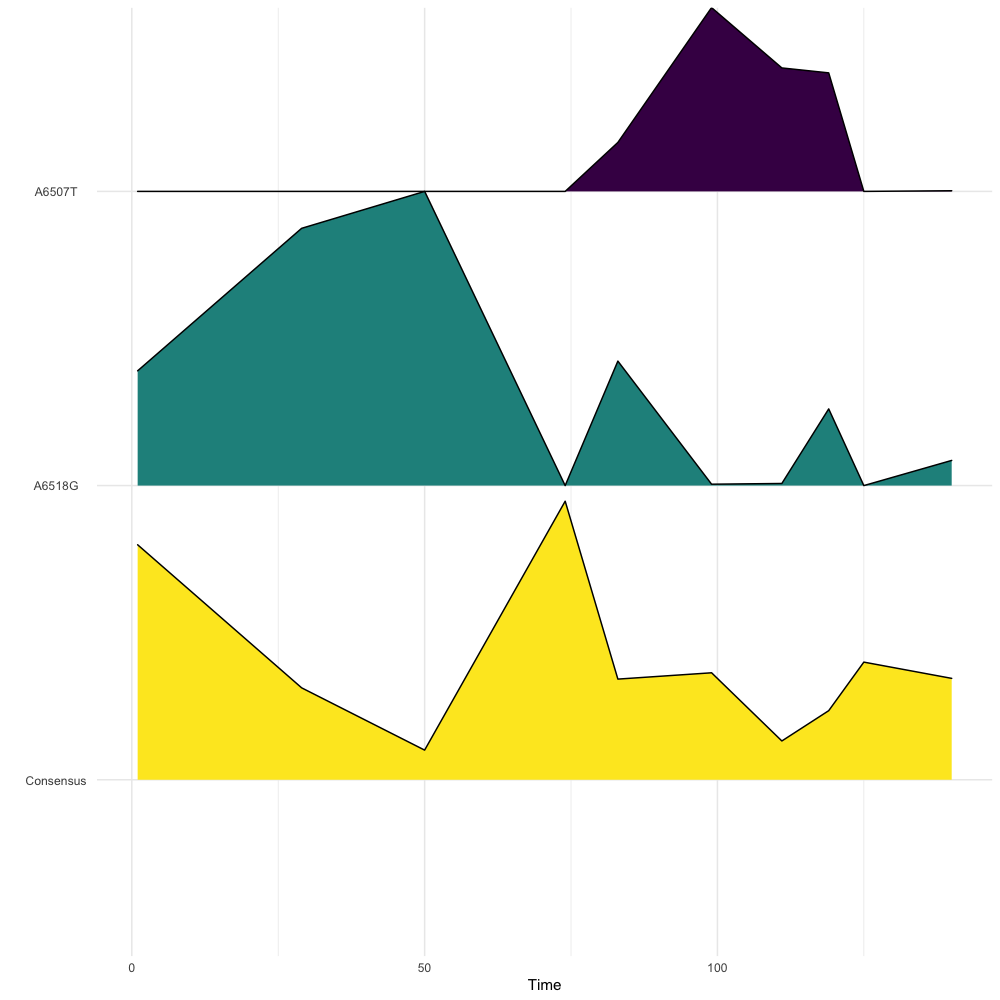

Temporary file deleted successfully.


In [77]:
# create ridgeplot for later joining

@rput haps
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")


R"""
# Ensure Haplotype is a character (in case it's a factor)
haps$Haplotype <- as.character(haps$Haplotype)

# Convert Haplotype to a factor with levels defined by tree_order, but in reverse order
haps$Haplotype <- factor(haps$Haplotype, levels = rev(tree_order))

# Reorder variant_label based on the reversed order of Haplotype
haps$variant_label <- factor(haps$variant_label, levels = unique(haps$variant_label[order(haps$Haplotype)]))

# Generate the plot
ridge_plot <- ggplot(haps, aes(x = as.numeric(Time), y = variant_label, fill = variant_label)) +
  geom_density_ridges(aes(height = as.numeric(Frequency)), stat = "identity", scale = 1) +  # Adjust scale for closer ridges
  theme_minimal() + 
  labs(x = "Time", y = "") +
  scale_fill_viridis(discrete = TRUE, direction = -1) +
  theme(legend.position = "none", 
        axis.text.y = element_text(hjust = 0.5))  # Center the y-axis text

# Save the plot with adjusted resolution and dimensions
png(filename = $output_path, width = 1000, height = 1000, res = 100)
print(ridge_plot)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
  img = load(output_path)
  display(img)

  # Delete the temporary image file after displaying
  rm(output_path; force = true)
  println("Temporary file deleted successfully.")
else
  println("File does not exist.")
end

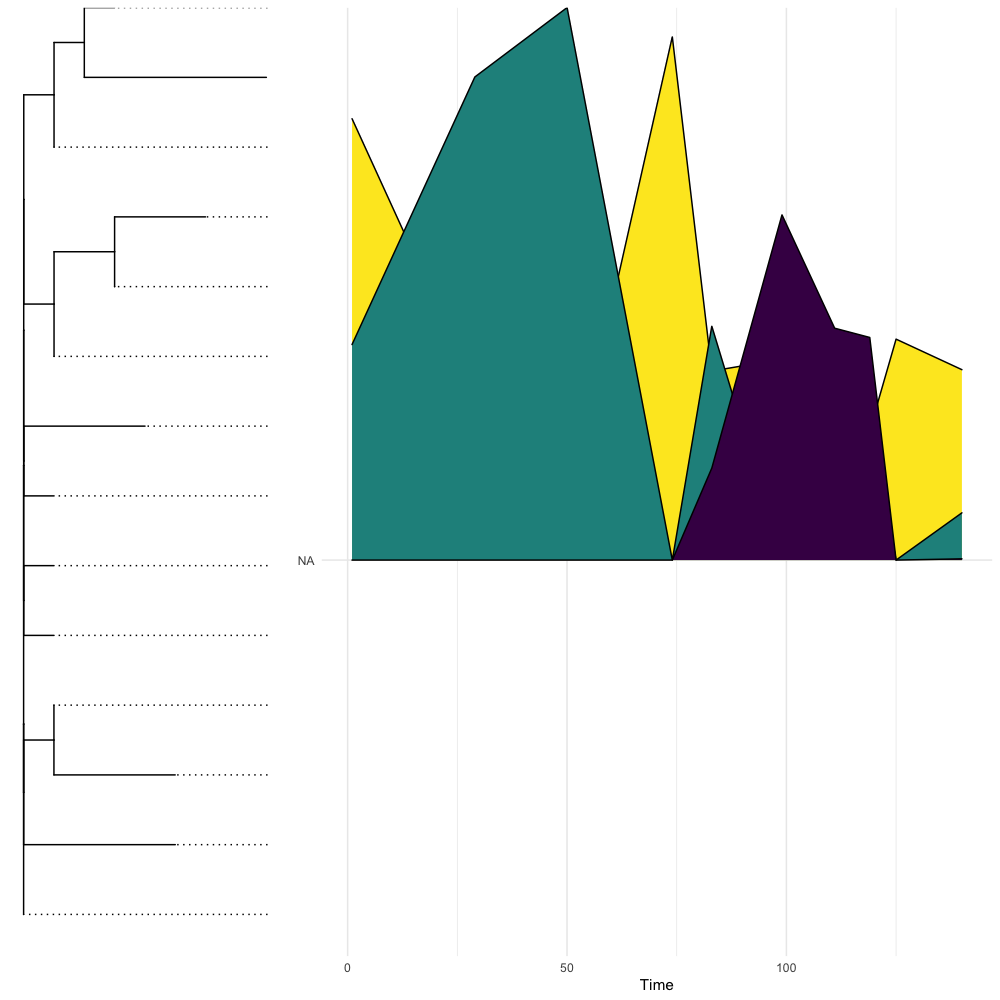

Temporary file deleted successfully.


In [78]:
# create ridgeplot for later joining

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

R"""
p <- ridge_plot %>% insert_left(tree_plot, width = 0.4)

# Save the plot with adjusted resolution and dimensions
png(filename = $output_path, width = 1000, height = 1000, res = 100)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)
  
    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
  else
    println("File does not exist.")
  end



In [79]:
R"""
# Check the ridgeline plot separately
print(p_ridges)

p_ridges <- ggplot(density_data, aes(x = x, y = label, height = y, fill = label)) +
  geom_ridgeline(stat = "identity", scale = 1.5, alpha = 0.8) +  # Adjust scale
  theme_ridges() + 
  theme(legend.position = "none")

# Adjust the width for better visibility
aligned_plot <- insert_right(p_tree, p_ridges, width = 0.8)

# Display the combined plot
aligned_plot
  
"""

RCall.REvalError: REvalError: Error: object 'p_ridges' not found